# 2CS SIL2-SIQ2 Lab02. Decision trees and Ensemble learning

<p style='text-align: right;font-style: italic;'>Designed by: Dr. Abdelkrime Aries</p>

In this lab, we will learn all about decision trees and ensemble learning.


**Team:**
- **Member 01**: Rezazi Mohamed Abdessamed
- **Member 02**: Mecherak Thanina
- **Group**: SIL2

In [2]:
import sys, timeit
from typing          import Tuple, List, Type, Union
from collections.abc import Callable

sys.version

'3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]'

In [3]:
import numpy             as np
import pandas            as pd 
import matplotlib.pyplot as plt 
import matplotlib
%matplotlib inline

np.__version__, pd.__version__, matplotlib.__version__

('1.24.3', '2.0.3', '3.7.2')

In [4]:
import sklearn

from sklearn.model_selection import train_test_split
# from sklearn.preprocessing   import StandardScaler
from sklearn.linear_model    import LogisticRegression
from sklearn.linear_model    import SGDClassifier
# from sklearn.multiclass      import OneVsRestClassifier
# from sklearn.multiclass      import OneVsOneClassifier
from sklearn.metrics         import accuracy_score
# from sklearn.metrics         import classification_report
# from sklearn.metrics         import log_loss

from   sklearn.tree    import DecisionTreeClassifier
from   sklearn.metrics import f1_score
from   sklearn         import tree
from   sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble     import BaggingClassifier
from sklearn.ensemble     import AdaBoostClassifier
from sklearn.ensemble     import StackingClassifier


sklearn.__version__

'1.3.0'

In [5]:
# This code is used to filter warnings concerning convergence
# In general, when the maximum number of iterations is not suffisant to converge
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)

## I. Algorithms implementation

In this section, we will try to implement ID3 and CART decision trees. 

### I.1. ID3

Here, we will try to implement ID3 algorithm for categorical features.

In [6]:
# Dataset play 

# outlook & temperature & humidity & windy
Xplay = np.array([
    ['sunny'   , 'hot' , 'high'  , 'no'],
    ['sunny'   , 'hot' , 'high'  , 'yes'],
    ['overcast', 'hot' , 'high'  , 'no'],
    ['rainy'   , 'mild', 'high'  , 'no'],
    ['rainy'   , 'cool', 'normal', 'no'],
    ['rainy'   , 'cool', 'normal', 'yes'],
    ['overcast', 'cool', 'normal', 'yes'],
    ['sunny'   , 'mild', 'high'  , 'no'],
    ['sunny'   , 'cool', 'normal', 'no'],
    ['rainy'   , 'mild', 'normal', 'no'],
    ['sunny'   , 'mild', 'normal', 'yes'],
    ['overcast', 'mild', 'high'  , 'yes'],
    ['overcast', 'hot' , 'normal', 'no'],
    ['rainy'   , 'mild', 'high'  , 'yes']
])

Yplay = np.array([
    'no', 
    'no', 
    'yes', 
    'yes', 
    'yes', 
    'no', 
    'yes', 
    'no', 
    'yes', 
    'yes', 
    'yes', 
    'yes', 
    'yes', 
    'no'
])

len(Xplay), len(Yplay)

(14, 14)

#### I.1.1. Probability

Given:
- $v$: a given value
- $S$: a set

the probability of this value given the set is its frequency in the set divided by the set's size

$$p(v/S) = \frac{|\{x / x \in S \text{ et } x = v\}|}{|S|}$$


**>> P.S. If the division always returns 0, try applying float(x) on integer numbers**

In [7]:
# TODO: Probability of a value given a set
def Pfn(v: str, S: np.ndarray) -> float: 
    return  np.count_nonzero(S == v) / S.size 

#=====================================================================
# UNIT TEST
#=====================================================================
# Result: 
# (0.6428571428571429,
#  0.35714285714285715,
#  0.2857142857142857,
#  0.35714285714285715)
#---------------------------------------------------------------------

Pfn('yes'     , Yplay      ), \
Pfn('sunny'   , Xplay[:, 0]), \
Pfn('overcast', Xplay[:, 0]), \
Pfn('rainy'   , Xplay[:, 0])

(0.6428571428571429,
 0.35714285714285715,
 0.2857142857142857,
 0.35714285714285715)

#### I.1.2. Uncertainty of a set

Given:
- $S$: a set
- $V$: a set of unique values of $S$ (vocabulary) 

Shannon's entropy is calculated as: 
$$H(S) = - \sum\limits_{v \in V} p(v/S) \log_2 p(v/S)$$


**>> P.S. np.log2 calculate log2 of a scalar, vector or matrix**

In [8]:
# TODO: Entropy
def Hfn(S: np.ndarray) -> float: 
    V = np.unique(S)
    entropy = 0
    for v in V:
        p = Pfn(v,S)
       
        entropy = entropy - (p * np.log2(p))
    return entropy 

#=====================================================================
# UNIT TESTs
#=====================================================================
# Result: 
# (0.9402859586706311, 1.5774062828523454)
#---------------------------------------------------------------------

Hfn(Yplay), Hfn(Xplay[:,0])

(0.9402859586706311, 1.5774062828523454)

#### I.1.3. Set splitting

**>> Nothing to code here**

Given:
- $Y$: a list to split.
- $A$: a list of an attribut's values (feature, column). 
- $v$: the value of $A$ on which $Y$ will be split.

The split is:
$$S_{A,v} = \{y^{(i)} \in Y / a^{(i)} \in A \wedge a^{(i)} = v\}\}$$


In [9]:
def split_ID3(Y: np.ndarray, A: np.ndarray, v: str) -> np.ndarray:
    msk = A == v
    return Y[msk]

#=====================================================================
# UNIT TEST
#=====================================================================
# Result: 
# array(['no', 'no', 'no', 'yes', 'yes'], dtype='<U3')
#---------------------------------------------------------------------

split_ID3(Yplay, Xplay[:,0], 'sunny')

array(['no', 'no', 'no', 'yes', 'yes'], dtype='<U3')

#### I.1.4. Information gain

Given:
- $Y$: a list to split.
- $A$: a list of an attribut's values (feature, column). 
- $V$: a list of unique values of $A$ (vocabulary).
- $(v/A)$: the probability of occurence of $v$ in $A$
- $Y_{A, v}$: subset of $Y$ where the values of $A$ equal $v$ (using the past implemented function split_ID3)

Informtion gain is calculated as: 

$$IG(Y, A) = H(Y) - \sum_{v \in V} p(v/A) H(Y_{A, v})$$

**>> The function must return a tuple (Information gain, entropy)**

In [10]:
# TODO: Information gain
def IGfn(Y: np.ndarray, A: np.ndarray) -> Tuple[float, float]:
    V = np.unique(A)
    entropy = Hfn(Y)
    ig      = entropy
    for v in V:
        ig = ig - Pfn( v,A) * Hfn(split_ID3(Y, A, v))

    return ig, entropy

#=====================================================================
# UNIT TEST
#=====================================================================
# Result: 
# (0.24674981977443933, 0.9402859586706311)
#---------------------------------------------------------------------

IGfn(Yplay, Xplay[:, 0])

(0.24674981977443933, 0.9402859586706311)

#### I.1.5. ID3 splitting feature selection

Given:
- $X[M, N]$: a matrix of $M$ samples and $N$ categorical features
- $Y[M]$: a vector of output labels

We want to find the feature which maximizes:

$$best_j = \arg\max_j IG(Y, X_j)$$

- **>> The function must return a tuple (nfeature order, IG, entropy)**

In [11]:
# TODO: ID3 splitting feature selection
def choose_split_ID3(X: np.ndarray, Y: np.ndarray) -> Tuple[int, float, float]: 
    bestj    = -1   # number of the best feature
    ig_bestj = -1.0 # IG of the best feature
    h_bestj  = -1.0 # Entropy of the best feature
    for j in range(X.shape[1]):
        [ig,enthropy]=IGfn(Y,X[:,j])
        if(ig>ig_bestj):
            ig_bestj=ig
            h_bestj=enthropy
            bestj=j

    return bestj, ig_bestj, h_bestj

#=====================================================================
# UNIT TEST
#=====================================================================
# Result: 
# (0, 0.24674981977443933, 0.9402859586706311)
#---------------------------------------------------------------------

choose_split_ID3(Xplay, Yplay)

(0, 0.24674981977443933, 0.9402859586706311)

#### I.1.6. Stopping Criterion

Given:
- $Y$: a set of outupt labels in a given node
- $h$: the homogeneity criterion. h = 0 ==> the set Y is homogeneous (same values)
- $nbr_min$: the minimum number of samples in a node. |Y| <= nbr_min ==> the node must be a leaf

the function must return:
- The name of the class: if the set is homogeneous or it contains a minimum number of elements
- None: otherwise

**>> HINT: use numpy.unique and numpy.argmax**

In [12]:
# TODO: ID3 Stopping Criterion
def stop_ID3(Y: np.ndarray, h: float, nbr_min: int) -> Union[str, None]:
    V = np.unique(Y)
    if h ==0:
        return Y[0]
    if Y.size <= nbr_min:
        nb_v = [np.count_nonzero(Y == v) for v in V]
        return V[np.argmax(nb_v)]

    return None

#=====================================================================
# UNIT TEST
#=====================================================================
# Result: 
# ('yes', 'no', None)
#---------------------------------------------------------------------

Y_t1 = np.array(['yes', 'yes', 'yes'])
Y_t2 = np.array(['yes', 'no', 'no'])

stop_ID3(Y_t1, Hfn(Y_t1), 2), \
stop_ID3(Y_t2, Hfn(Y_t2), 4), \
stop_ID3(Y_t2, Hfn(Y_t2), 2)

('yes', 'no', None)

#### I.1.7. Tree construction

**>> Nothing to code here**


In [13]:
# A class to represent a node
class Node(object): 
    
    nbr = 0
    
    def __init__(self, f:int, ig:float, h:float, depth:int): 
        self.f        = f        # le numéro du caractéristique de dévision dans X
        self.ig       = ig         # le IG de division
        self.h        = h          # l'entropie H
        self.depth    = depth      # la profondeur du noeud
        self.children = {}         # les fils ; un dictionnaire valeur : noeud
        self.cls      = ''         # la classe si ce noeud est final (s'il n'y a pas de fils)
        self.indent   = '    '     # indentation lorsqu'on génère le code
    
    # Cette fonction est pour transformer le noeud à une string
    #Ici, nous avons redéfini cette fonction afin qu'elle écrive l'arbre 
    #sous form d'un algorithme ; c'est un parser 
    def __str__(self):
        
        indent = self.indent * self.depth # indentation : esthetique
        
        # s'il n'y a pas de fils, le noeud est terminal ; on imprime la classe
        if (len(self.children)==0):
            return indent + 'Y IS "' + self.cls + '"\n'
        
        # s'il y a des fils, on boucle sur les fils et on imprime des SI ... ALORS
        res = ""
        for f_v in self.children:
            res += indent + 'IF X[' + str(self.f) + '] IS "' + str(f_v) 
            res += '" THEN\n' + str(self.children[f_v])
        return res
    
    # predirct a sample
    def predict(self, x: List[str]) -> str: 
        
        # If the node is final, return its class
        if (len(self.children)==0):
            return self.cls
        
        # If the value of this node's feature is not in its children
        # return np.nan
        if x[self.f] not in self.children: 
            return np.nan
        
        # Otherwise, it returns the prediction of the child
        return self.children[x[self.f]].predict(x)
    
    def graphviz(self): 
        
        nid = 'N' + str(Node.nbr)
        Node.nbr += 1
        
        if (len(self.children)==0):
            return nid, nid + '[label="' + self.cls + '" shape=ellipse];\n'
        
        res  = nid + '[label="X[' + str(self.f) + ']\\n'
        # res += 'H = ' + str(self.h) + '\\n'
        # res += 'IG = ' + str(self.ig) + '"];\n'
        res += 'H = {:.5f}\\n'.format(self.h)
        res += 'IG = {:.5f}"];\n'.format(self.ig)
        for f in self.children:
            vid, code = self.children[f].graphviz()
            res += code
            res += nid + ' -> ' + vid + ' [label="' + f + '"];\n'
        return nid, res
    

def fit_ID3(X:np.ndarray, Y:np.ndarray, nbr_min:int=0, depth:int=0): 
    
    bestj, ig_bestj, h_bestj = choose_split_ID3(X, Y)
    noeud = Node(bestj, ig_bestj, h_bestj, depth)
    cls = stop_ID3(Y, h_bestj, nbr_min)
    if cls:
        noeud.cls = cls 
        return noeud 

    depth += 1 
    for v in np.unique(X[:, bestj]):
        msk = X[:, bestj] == v 
        X_v = X[msk]
        Y_v = Y[msk]
        child = fit_ID3(X_v, Y_v, nbr_min=nbr_min, depth=depth)
        noeud.children[v] = child
    
    return noeud

#=====================================================================
# UNIT TEST
#=====================================================================
# Result: 
# The code
# IF X[0] IS "overcast" THEN
#     Y IS "yes"
# IF X[0] IS "rainy" THEN
#     IF X[3] IS "no" THEN
#         Y IS "yes"
#     IF X[3] IS "yes" THEN
#         Y IS "no"
# IF X[0] IS "sunny" THEN
#     IF X[2] IS "high" THEN
#         Y IS "no"
#     IF X[2] IS "normal" THEN
#         Y IS "yes"
#
# 'yes'
#---------------------------------------------------------------------

DTplay = fit_ID3(Xplay, Yplay)

print('The code')
print(DTplay)

# Test a sample
DTplay.predict(['rainy', 'temperature_makanche', 'humidity_makanche', 'no'])

The code
IF X[0] IS "overcast" THEN
    Y IS "yes"
IF X[0] IS "rainy" THEN
    IF X[3] IS "no" THEN
        Y IS "yes"
    IF X[3] IS "yes" THEN
        Y IS "no"
IF X[0] IS "sunny" THEN
    IF X[2] IS "high" THEN
        Y IS "no"
    IF X[2] IS "normal" THEN
        Y IS "yes"



'yes'

#### I.1.8. Final product

**>> Nothing to code here**

In [14]:
class ID3(object): 
    
    def fit(self, X, Y, features=[], clsname='', nbr_min=0):
        self.tree = fit_ID3(X, Y, nbr_min=nbr_min)
        code = str(self.tree)
        if len(clsname) > 0: 
            code = code.replace('Y', clsname)
        for i in range(len(features)): 
            code = code.replace('X[' + str(i) + ']', features[i])
        self.code = code
        self.features = features
    
    def predict(self, X): 
        predictions = []
        for i in range(len(X)): 
            predictions.append(self.tree.predict(X[i, :]))
        return predictions
    
    def graphviz(self): 
        nid, code = self.tree.graphviz()
        res  = 'digraph Tree {\n'
        res += 'node [shape=box] ;'
        for i in range(len(self.features)): 
            code = code.replace('X[' + str(i) + ']', self.features[i])
        res += code
        res += '}'
        return res

#=====================================================================
# UNIT TEST
#=====================================================================
# Result: 
# IF outlook IS "overcast" THEN
#     play IS "yes"
# IF outlook IS "rainy" THEN
#     IF windy IS "no" THEN
#         play IS "yes"
#     IF windy IS "yes" THEN
#         play IS "no"
# IF outlook IS "sunny" THEN
#     IF humidity IS "high" THEN
#         play IS "no"
#     IF humidity IS "normal" THEN
#         play IS "yes"
#---------------------------------------------------------------------

features=['outlook', 'temperature', 'humidity', 'windy']

id3_classifier = ID3()
id3_classifier.fit(Xplay, Yplay, features=features, clsname='play')
print(id3_classifier.code)

IF outlook IS "overcast" THEN
    play IS "yes"
IF outlook IS "rainy" THEN
    IF windy IS "no" THEN
        play IS "yes"
    IF windy IS "yes" THEN
        play IS "no"
IF outlook IS "sunny" THEN
    IF humidity IS "high" THEN
        play IS "no"
    IF humidity IS "normal" THEN
        play IS "yes"



In [15]:
# !pip install graphviz
# Also you need to install the graphviz backend in the system
# Lien : https://graphviz.org/download/

In [16]:
# It's just a visualization of the graph
# If it doesn't work, it doesn't matter
try:
    from IPython.display import SVG
    from graphviz        import Source
    from IPython.display import display
    
    graph = Source(id3_classifier.graphviz())
    display(SVG(graph.pipe(format='svg')))

except ImportError:
    print('You have to install graphviz: https://graphviz.org/download/')

You have to install graphviz: https://graphviz.org/download/


### I.2. CART

Here, we will try to implement CART algorithm for numerical features.


In [17]:
# temperature & humidity & windy
Xnplay = np.array([
    [30, 85, 0],
    [27, 90, 1],
    [28, 78, 0],
    [21, 96, 0],
    [20, 80, 0],
    [18, 70, 1],
    [18, 65, 1],
    [22, 95, 0],
    [21, 70, 0],
    [24, 80, 0],
    [24, 70, 1],
    [22, 90, 1],
    [27, 75, 0],
    [22, 80, 1]
])

Ynplay = Yplay

len(Xnplay), len(Ynplay)

(14, 14)

#### I.2.1. Gini diversity index (Gini impurity)

Given:
- $S$: a set
- $V$: a set of unique values of $S$ (vocabulary) 

Gini is calculated by: 
$$Gini(S) = \sum\limits_{v \in V} p(v/S) (1-p(v/S)) = 1 - \sum\limits_{v \in V} p(v/S)^2 $$

In [18]:
# TODO: Gini impurity
def Gini(S: np.ndarray) -> float:  
    V = np.unique(S)
    gini = 1
    for v in V:
        gini = gini - (Pfn(v,S))**2
    return gini 

#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# 0.4591836734693877
#---------------------------------------------------------------------

Gini(Ynplay)

0.4591836734693877

#### I.2.2. Set splitting

**>> Nothing to code here**

Given:
- $Y$: a list to split.
- $A$: a list of an attribut's values (feature, column). 
- $v$: the value of $A$ on which $Y$ will be split.


The list is split into two subsets:
- $Y_L$: a subset of $Y$ where $A > v$
- $Y_R$: a subset of $Y$ where $A \le v$


In [19]:
def split_CART(Y:np.ndarray, A:np.ndarray, v:float):
    msk = A > v
    return Y[msk], Y[~msk]

#=====================================================================
# UNIT TEST
#=====================================================================
# Result: 
# (array(['no', 'no', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes',
#         'no'], dtype='<U3'),
#  array(['yes', 'no', 'yes'], dtype='<U3'))
#---------------------------------------------------------------------

split_CART(Ynplay, Xnplay[:,0], 20)

(array(['no', 'no', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes',
        'no'], dtype='<U3'),
 array(['yes', 'no', 'yes'], dtype='<U3'))

#### I.2.3. Gini impurity for the split

Given: 
- $Y$: a list to split.
- $S_L, G_R$: subsets left and right
- $|S| = |S_L| + |S_R|$

Gini impurity for the split is calculated as: 

$$Gini_{split}(S_L, S_R) = \frac{|S_L|}{|S|} Gini(S_L) + \frac{|S_R|}{|S|} Gini(S_R)$$


In [20]:
# TODO: Gini impurity for the split
def Gini_split(S_L: np.ndarray, S_R: np.ndarray) -> float:  
    S_len = float(len(S_L) + len(S_R)) 
    return (float(len(S_L))/S_len) * Gini(S_L) + (float(len(S_R))/S_len) * Gini(S_R)

#=====================================================================
# UNIT TEST
#=====================================================================
# Result: 
# 0.4588744588744589
#---------------------------------------------------------------------

S_L, S_R = split_CART(Ynplay, Xnplay[:, 0], 20)
Gini_split(S_L, S_R)

0.4588744588744589

#### I.2.4. CART splitting feature and value selection

Algorithm:
- For each feature $X_j$ 
   - For each value $v \in unique(X_j)$
       1. Split $Y$ given $X_j$ and $v$
       1. Calculate Gini diversity of the division
       1. Save **bestj** the order of the feature which minimizes Gini impurity for the split
       1. Save Gini diversity of the division minimal **gini_bestj**
       1. Save the value of split **v_jbest**
       

In [21]:
# TODO: Choice of CART splitting feature and value
def choose_split_CART(X: np.ndarray, Y: np.ndarray) -> Tuple[int, float, float]: 
    bestj      = -1
    gini_bestj =  1.0
    v_bestj    = -1.0
    j = -1
    for Xj in X.T:
        list = []
        j += 1 
        for v in np.unique(Xj):
            S_G, S_D = split_CART(Y, Xj, v)
            list.append(Gini_split(S_G, S_D))
        if list:
            gini = list[np.argmin(list)]
            if gini < gini_bestj:
                gini_bestj = gini
                bestj = j
                v_bestj = Xj[list.index(gini)]
    return bestj, gini_bestj, v_bestj

#=====================================================================
# UNIT TEST
#=====================================================================
# Result: 
# (1, 0.3936507936507937, 80)
#---------------------------------------------------------------------

choose_split_CART(Xnplay, Ynplay)

(1, 0.3936507936507937, 80)

#### I.2.5. Stopping Criterion

**>> Nothing to code here** 

The same as stop_ID3. Gini is passed in arguments instead of Entropy.

In [22]:
stop_CART = stop_ID3

#=====================================================================
# UNIT TEST
#=====================================================================
# Result: 
# ('yes', 'no', None)
#---------------------------------------------------------------------

Y_t1 = np.array(['yes', 'yes', 'yes'])
Y_t2 = np.array(['yes', 'no', 'no'])

stop_CART(Y_t1, Hfn(Y_t1), 2), \
stop_CART(Y_t2, Hfn(Y_t2), 4), \
stop_CART(Y_t2, Hfn(Y_t2), 2)

('yes', 'no', None)

#### I.2.6. Tree construction

**>> Nothing to code here**

In [23]:
# Comme Noeud, mais il faut changer un peu, puisqu'on teste sur des 
# valeurs numériques aussi
# Le code sera plus utilisable si on crée une classe commune et on hérite
# Mais, je n'ai pas le temps pour tout ça (DEAL WITH IT)
class NoeudBin(object): 
    
    nbr = 0
    
    def __init__(self, f:int, val:int, gini:float, depth:int): 
        self.f      = f        # le numéro du caractéristique de dévision dans X
        self.val    = val        # la valeur du noeud
        self.gini   = gini       # le Gini de division
        self.depth     = depth # la profondeur du noeud
        self.children = []         # les fils ; un tableau de deux noeuds: S_G, S_D
        self.cls    = ''         # la classe si ce noeud est final (s'il n'y a pas de fils)
        self.indent = '    '     # indentation lorsqu'on génère le code
    
    # Cette fonction est pour transformer le noeud à une string
    #Ici, nous avons redéfini cette fonction afin qu'elle écrive l'arbre 
    #sous form d'un algorithme ; c'est un parser 
    def __str__(self):
        
        indent = self.indent * self.depth # indentation : esthetique
        
        # s'il n'y a pas de fils, le noeud est terminal ; on imprime la classe
        if (len(self.children)==0):
            return indent + 'Y IS "' + self.cls + '"\n'
         
        prefix = ' > '
        suffix = ''
        
        # s'il y a des fils, on boucle sur les fils et on imprime des SI ... ALORS SINON
        res  = ''
        res += indent + 'IF X[' + str(self.f) + '] ' + prefix + str(self.val) + suffix 
        res += ' THEN\n' + str(self.children[0])
        res += indent + 'ELSE\n' + str(self.children[1])
        return res
    
    # predire un échantillon
    def predict(self, x: List[float]): 
        
        # If the node is a leaf
        if (len(self.children)==0):
            return self.cls
        
        # Otherwise
        if x[self.f] > self.val:
            return self.children[0].predict(x)
        return self.children[1].predict(x)

    
    # Generate graphviz code
    def graphviz(self): 
        
        nid = 'N' + str(NoeudBin.nbr)
        NoeudBin.nbr += 1
        
        # If the node is a leaf
        if (len(self.children)==0):
            return nid, nid + '[label="' + self.cls + '" shape=ellipse];\n'
        
        # Otherwise, 
        # loop over children and print IF ... ELSE
        prefix = '] > '
        res = nid + '[label="X[' + str(self.f) + prefix + str(self.val) + '\\n'
        res += 'Gini = {:.5f}"];\n'.format(self.gini)
        vid_L, code_L = self.children[0].graphviz()
        vid_R, code_R = self.children[1].graphviz()
        
        res += code_L + code_R
        res += nid + ' -> ' + vid_L + ' [label="TRUE"];\n'
        res += nid + ' -> ' + vid_R + ' [label="FALSE"];\n'
        return nid, res

# créer l'arbre de décision à partir d'un ensemble X et Y
def fit_CART(X:np.ndarray, Y:np.ndarray, depth:int=0, nbr_min:int=0): 
    
    # Chercher le meilleur caractéristique de X pour diviser Y
    bestj, gini_bestj, v_bestj = choose_split_CART(X, Y)
    # Créer un noeud
    noeud = NoeudBin(bestj, v_bestj, gini_bestj, depth)
    # Si l'entropie est 0 donc le noeud est terminal, élagage
    
    cls = stop_CART(Y, gini_bestj, nbr_min)
    if cls:
        noeud.cls = cls # la classe du noeud
        return noeud # retourner le noeud 
     
    
    # Sinon, si le noeud n'est pas terminal, on crée ces fils
    depth += 1 # la profondeur de ces fils
    # création des deux fils
    
    msk = X[:, bestj] > v_bestj
    
    X_L = X[msk]
    Y_L = Y[msk]
    child_L = fit_CART(X_L, Y_L, depth, nbr_min)
    X_R = X[~msk]
    Y_R = Y[~msk]
    child_R = fit_CART(X_R, Y_R, depth, nbr_min)
    noeud.children.append(child_L)
    noeud.children.append(child_R)
    
    return noeud

#=====================================================================
# UNIT TEST
#=====================================================================
# Result: 
# The Code
# IF X[1]  > 80 THEN
#     IF X[0]  > 22 THEN
#         Y IS "no"
#     ELSE
#         IF X[0]  > 21 THEN
#             Y IS "no"
#         ELSE
#             Y IS "yes"
# ELSE
#     IF X[2]  > 0 THEN
#         IF X[1]  > 70 THEN
#             Y IS "no"
#         ELSE
#             IF X[0]  > 18 THEN
#                 Y IS "yes"
#             ELSE
#                 Y IS "no"
#     ELSE
#         Y IS "yes"
#---------------------------------------------------------------------

tree_nplay = fit_CART(Xnplay, Ynplay)

print('The Code')
print(tree_nplay)

ValueError: attempt to get argmax of an empty sequence

#### I.2.7. Final product

**>> Nothing to code here**

In [24]:
class CART(object): 
    
    def fit(self, X:np.ndarray, Y:np.ndarray, features:List[str]=[], clsname:str='', nbr_min:int=0):
        self.tree = fit_CART(X, Y, 0, nbr_min)
        code = str(self.tree)
        if len(clsname) > 0: 
            code = code.replace('Y', clsname)
        for i in range(len(features)): 
            code = code.replace('X[' + str(i) + ']', features[i])
        self.code   = code
        self.features = features
    
    def predict(self, x:np.ndarray): 
        predictions = []
        for i in range(len(x)): 
            predictions.append(self.tree.predict(x[i, :]))
        return predictions
    
    def graphviz(self): 
        nid, code = self.tree.graphviz()
        res  = 'digraph Tree {\n'
        res += 'node [shape=box] ;'
        for i in range(len(self.features)): 
            code = code.replace('X[' + str(i) + ']', self.features[i])
        res += code
        res += '}'
        return res

#=====================================================================
# UNIT TEST
#=====================================================================
# Result: 
# IF humidity  > 80 THEN
#     IF temperature  > 22 THEN
#         play IS "no"
#     ELSE
#         IF temperature  > 21 THEN
#             play IS "no"
#         ELSE
#             play IS "yes"
# ELSE
#     IF windy  > 0 THEN
#         IF humidity  > 70 THEN
#             play IS "no"
#         ELSE
#             IF temperature  > 18 THEN
#                 play IS "yes"
#             ELSE
#                 play IS "no"
#     ELSE
#         play IS "yes"
#---------------------------------------------------------------------

features=['temperature', 'humidity', 'windy']

cart_classifier = CART()
cart_classifier.fit(Xnplay, Ynplay, features=features, clsname='play')
print(cart_classifier.code)

ValueError: attempt to get argmax of an empty sequence

In [25]:
# C'est juste une visualisation du graphe
# Si ça ne marche pas, ce n'ai pas grave
try:
    from IPython.display import SVG
    from graphviz import Source
    from IPython.display import display
    
    graph = Source(cart_classifier.graphviz())
    display(SVG(graph.pipe(format='svg')))

except ImportError:
    print('You have to install graphviz: https://graphviz.org/download/')

You have to install graphviz: https://graphviz.org/download/


## II. Application and Analysis

In this section, we will test different concepts by running an experiment, formulating a hypothesis and trying to justify it. 
We will use [Cars Data](https://www.kaggle.com/abineshkumark/carsdata) just for 3 classes: US., Euroupe. and Japan. 

In [64]:
# Dataset import
cars_data = pd.read_csv('data/cars.csv', skipinitialspace=True)
# Remove missing values
cars_data.dropna(inplace=True)
# Yay! We did it! These are the first samples
cars_data.head()

,mpg,cylinders,cubicinches,hp,weightlbs,time-to-60,year,brand
0,14.0,8,350.0,165,4209.0,12,1972,US.
1,31.9,4,89.0,71,1925.0,14,1980,Europe.
2,17.0,8,302.0,140,3449.0,11,1971,US.
3,15.0,8,400.0,150,3761.0,10,1971,US.
4,30.5,4,98.0,63,2051.0,17,1978,US.


In [26]:
cars_data.dtypes

mpg            float64
cylinders        int64
cubicinches    float64
hp               int64
weightlbs      float64
time-to-60       int64
year             int64
brand           object
dtype: object

In [65]:
X_cars = cars_data.values[:, :-1]
Y_cars = cars_data.values[:,  -1]

X_cars_train, X_cars_test, Y_cars_train, Y_cars_test = train_test_split(X_cars, 
                                                                        Y_cars, 
                                                                        test_size=0.2, 
                                                                        random_state=0) 

X_cars_train.shape, X_cars_test.shape

((204, 7), (52, 7))

### II.1. Decision trees and Random forests

We want to test the effect of different hyper-parameters of decision trees.


In Scikit-learn's implemtation (**DecisionTreeClassifier**), features are always randomly permuted at each split.
The tree will be undeterministic (which is good for overfitting, but not good for tessting the effect of hyper-parameters).
In this case, we stop this property using **random_state=0**.

#### II.1.1. Feature selection criteria

In scikit-learn, there is only CART which can use both: 
1. Entropy
1. Gini

Both will generate slightly different decision tree structures. We want to test the effect of the structure on training and test.

In [66]:
Xtrain = X_cars_train
Ytrain = Y_cars_train
Xtest  = X_cars_test
Ytest  = Y_cars_test
fnames = cars_data.columns


gini_stats         = []
entropy_stats      = []
gini_classifier    = DecisionTreeClassifier(criterion='gini'   , random_state=0, min_samples_leaf=7)
entropy_classifier = DecisionTreeClassifier(criterion='entropy', random_state=0, min_samples_leaf=7)

# ============ GINI ====================
# ................ Train ..............
temps_debut = timeit.default_timer()
gini_classifier.fit(Xtrain, Ytrain)
gini_stats.append(timeit.default_timer() - temps_debut)
# ........... Evaluation train .........
gini_stats.append(f1_score(Ytrain, gini_classifier.predict(Xtrain), average='micro'))
# ................ Test ................
temps_debut = timeit.default_timer()
Ychoix_pred = gini_classifier.predict(Xtest)
gini_stats.append(timeit.default_timer() - temps_debut)
# ........... Evaluation test ...........
gini_stats.append(f1_score(Ytest, Ychoix_pred, average='micro'))

# =========== Entropy ==================
# ............ Train ............
temps_debut = timeit.default_timer()
entropy_classifier.fit(Xtrain, Ytrain)
entropy_stats.append(timeit.default_timer() - temps_debut)
# ........... Evaluation train ........
entropy_stats.append(f1_score(Ytrain, entropy_classifier.predict(Xtrain), average='micro'))
# ................ Test ................
temps_debut = timeit.default_timer()
Ychoix_pred = entropy_classifier.predict(Xtest)
entropy_stats.append(timeit.default_timer() - temps_debut)
# ........... Evaluation test ...........
entropy_stats.append(f1_score(Ytest, Ychoix_pred, average='micro'))

print('Fin')

Fin


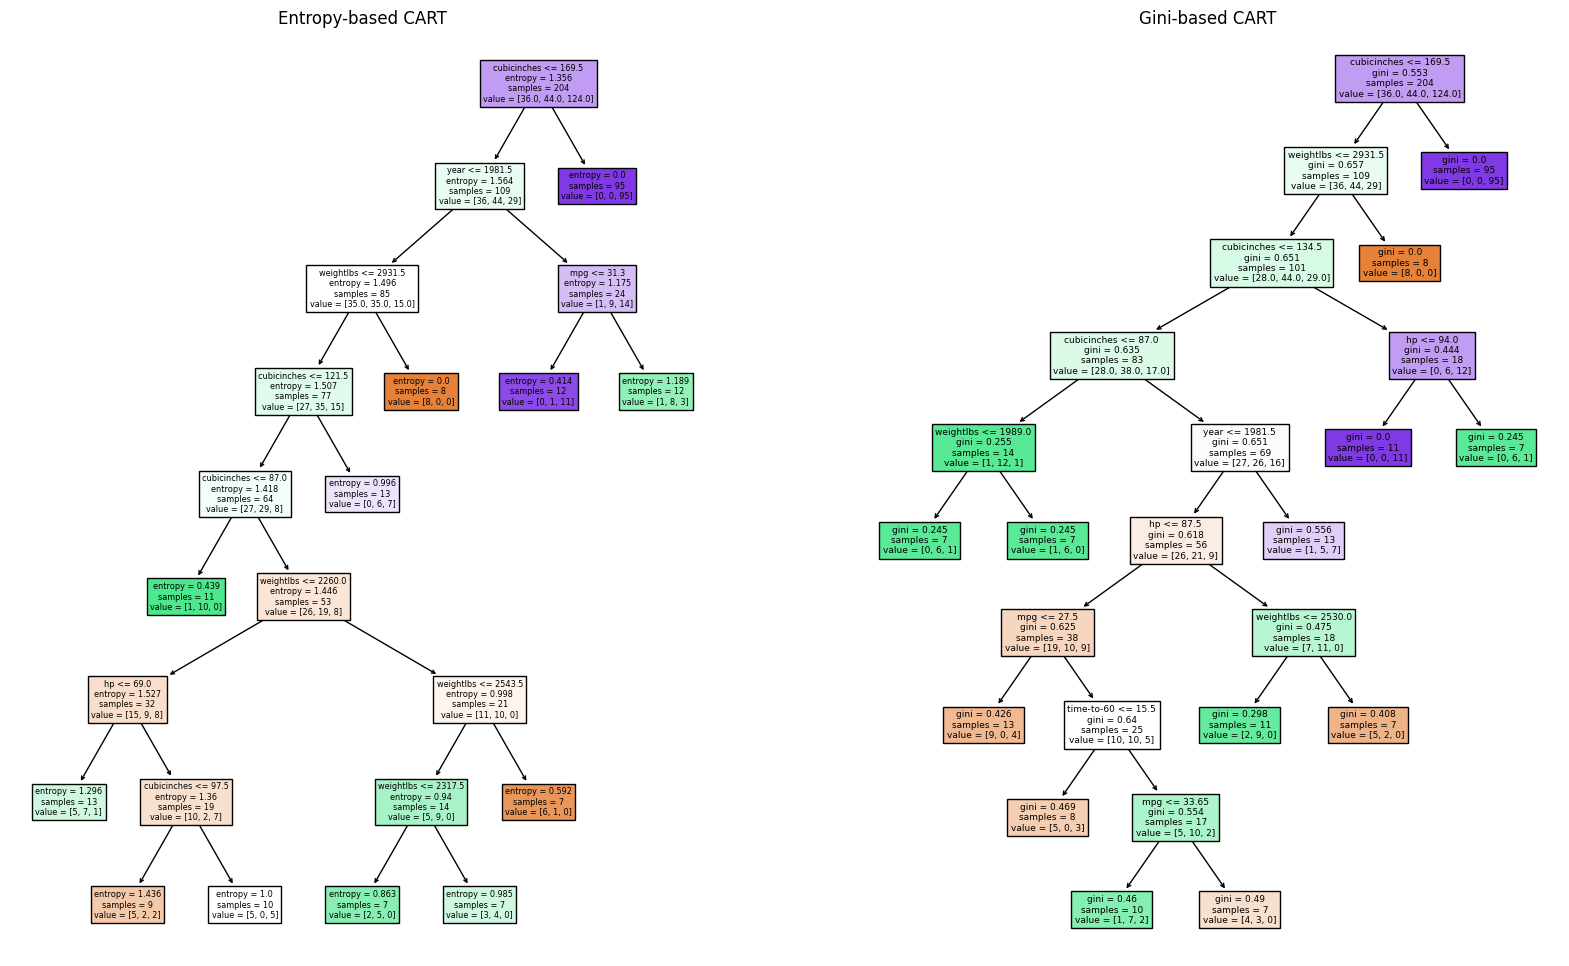

In [29]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figwidth (20)
fig.set_figheight(12)
tree.plot_tree(entropy_classifier, ax=ax1, feature_names=fnames, filled=True)
tree.plot_tree(gini_classifier   , ax=ax2, feature_names=fnames, filled=True)
ax1.set_title('Entropy-based CART')
ax2.set_title('Gini-based CART')
plt.show()

In [67]:
pd.DataFrame({
    'Criteria' : ['Train Time', 'Train F1', 'Test Time', 'Test F1'],
    'Entropy-based CART' : entropy_stats,
    'Gini-based CART'    : gini_stats
})

,Criteria,Entropy-based CART,Gini-based CART
0,Train Time,0.004074,0.025099
1,Train F1,0.838235,0.872549
2,Test Time,0.000526,0.000485
3,Test F1,0.788462,0.807692


**TODO: Analyze the results**

1. Compare the two trees' structures (depth, leafs number, position of leafs)
1. Justify the training time based on the algorithms and trees structures
1. Justify the test time based on the algorithms and trees structures  

**Answers**

1. gini_based cart has more nodes than the enthropy one besides , gini has more depth than enthropy 
1. that the Gini-based CART took longer to train.In ourcase, the Gini-based CART (fit_CART) took longer to train than the Entropy-based ID3 (fit_ID3). This is due to the fact that the Gini impurity measure requires more computations than the entropy measure because The Gini-based CART has more nodes (25 nodes) than the Entropy-based CART (23 nodes). More nodes in the tree mean more decisions or splits were made when building the tree. Each decision or split requires calculations  which take time. Therefore, a tree with more nodes would generally take longer to train.
1.  from the results, it appears that the test times for both the Entropy-based CART and the Gini-based CART are very similar. This is due to the fact that the difference in depth between the two trees is not significant enough to cause a noticeable difference in test time.

#### II.1.2. Maximum depth

We want to test the effect of stopping creteria "maximum depth", so we used F1 score as classification quality measure.

For each maximum depth, we trained a decision/random forest tree and calculated its F1 score on training data (to test convergence) and on test data (to test generalization).

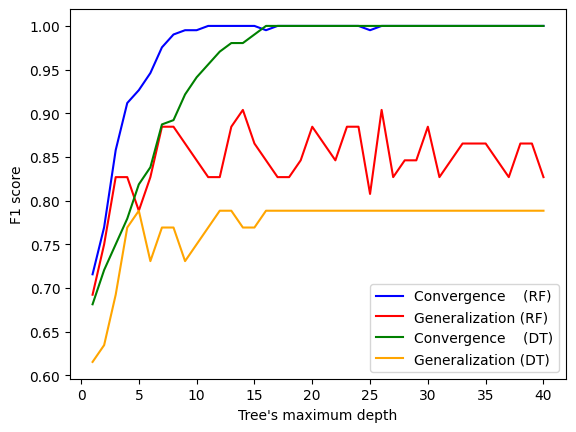

In [31]:
MAX_DEPTH     = 40
MAX_DEPTH_lst = range(1, MAX_DEPTH+1, 1)

f1_trn_md_DT  = []
f1_tst_md_DT  = []
f1_trn_md_RF  = []
f1_tst_md_RF  = []
for max_depth in MAX_DEPTH_lst:
    mdl_DT = DecisionTreeClassifier(random_state=0, max_depth=max_depth)
    mdl_DT.fit(X_cars_train, Y_cars_train)
    f1_trn_md_DT.append(f1_score(Y_cars_train, mdl_DT.predict(X_cars_train), average='micro'))
    f1_tst_md_DT.append(f1_score(Y_cars_test , mdl_DT.predict(X_cars_test) , average='micro'))

    mdl_RF = RandomForestClassifier(n_estimators=30, max_depth=max_depth)
    mdl_RF.fit(X_cars_train, Y_cars_train)
    f1_trn_md_RF.append(f1_score(Y_cars_train, mdl_RF.predict(X_cars_train), average='micro'))
    f1_tst_md_RF.append (f1_score(Y_cars_test , mdl_RF.predict(X_cars_test) , average='micro'))


plt.plot(MAX_DEPTH_lst, f1_trn_md_RF, color='blue'  , label='Convergence    (RF)')
plt.plot(MAX_DEPTH_lst, f1_tst_md_RF, color='red'   , label='Generalization (RF)')
plt.plot(MAX_DEPTH_lst, f1_trn_md_DT, color='green' , label='Convergence    (DT)')
plt.plot(MAX_DEPTH_lst, f1_tst_md_DT, color='orange', label='Generalization (DT)')
plt.ylabel('F1 score')
plt.xlabel('Tree\'s maximum depth')
plt.legend()
#plt.rcParams["figure.figsize"] = (3,7)
plt.show()

**TODO: Analyze the results**

1. Why F1 score (convergence) is not enhanced after depth=17 in decision trees (DT)?
1. Why F1 score (convergence) is not enhanced after depth=17 in decision trees (DT)?
1. Why Random forests (RF) converge better then decision trees (DT) with less maximum depth? 
1. Why Random forests (RF) generalize better then decision trees (DT)? 

**Answers**

1. The F1 score (convergence) for Decision Trees (DT) not improving after a depth of 17 is due to the model reaching a point of saturation where additional depth does not contribute to learning more complex patterns in the training data.

In other words, the model has learned as much as it can from the training data up to a depth of 17, and increasing the depth beyond this point does not result in the model fitting the training data any better
1. ...
1. Random Forests (RF) converge better than Decision Trees (DT) with less maximum depth primarily due to their ensemble nature. RFs generate multiple Decision Trees on different subsets of the training data and average their predictions. This reduces variance and overfitting, allowing RFs to converge faster. Additionally, each tree in an RF uses a random subset of features, making the trees uncorrelated and further reducing overfitting

1. By creating multiple Decision Trees on different subsets of the training data and averaging their predictions, RFs effectively reduce variance and overfitting. This makes RFs more robust and better at generalizing to unseen data

#### II.1.3. Minimum leaf samples

We want to test the effect of stopping creteria "mimimum samples in leafs", so we used F1 score as classification quality measure.

For each minimum leaf samples number, we trained a decision tree/random forest and calculated its F1 score on training data (to test convergence) and on test data (to test generalization).

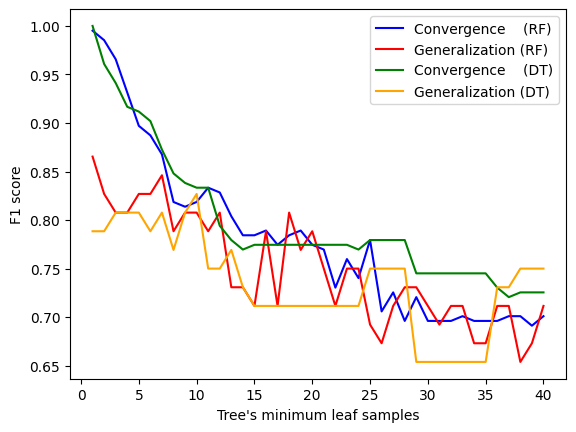

In [32]:
MIN_LEAF    = 40
MIN_LEAF_lst = range(1, MIN_LEAF+1, 1)

f1_trn_ml_DT = []
f1_tst_ml_DT = []
f1_trn_ml_RF = []
f1_tst_ml_RF = []
for min_samples_leaf in MIN_LEAF_lst:
    mdl_DT = DecisionTreeClassifier(random_state=0, min_samples_leaf=min_samples_leaf)
    mdl_DT.fit(X_cars_train, Y_cars_train)
    f1_trn_ml_DT.append(f1_score(Y_cars_train, mdl_DT.predict(X_cars_train), average='micro'))
    f1_tst_ml_DT.append(f1_score(Y_cars_test , mdl_DT.predict(X_cars_test) , average='micro'))

    mdl_RF = RandomForestClassifier(n_estimators=30, min_samples_leaf=min_samples_leaf)
    mdl_RF.fit(X_cars_train, Y_cars_train)
    f1_trn_ml_RF.append(f1_score(Y_cars_train, mdl_RF.predict(X_cars_train), average='micro'))
    f1_tst_ml_RF.append(f1_score(Y_cars_test , mdl_RF.predict(X_cars_test) , average='micro'))


plt.plot(MIN_LEAF_lst, f1_trn_ml_RF, color='blue'  , label='Convergence    (RF)')
plt.plot(MIN_LEAF_lst, f1_tst_ml_RF, color='red'   , label='Generalization (RF)')
plt.plot(MIN_LEAF_lst, f1_trn_ml_DT, color='green' , label='Convergence    (DT)')
plt.plot(MIN_LEAF_lst, f1_tst_ml_DT, color='orange', label='Generalization (DT)')
plt.ylabel('F1 score')
plt.xlabel('Tree\'s minimum leaf samples')
plt.legend()
#plt.rcParams["figure.figsize"] = (3,7)
plt.show()

**TODO: Analyze the results**
1. Why F1 score of decision trees (DT) gets worst when increasing the minimum leaf samples?
1. Why F1 score of decision trees (DT) gets better then random forests when increasing the minimum leaf samples?

**Answers**

1.  the F1 score decreases because the model’s ability to correctly classify instances is reduced.  because Increasing the minimum leaf samples in a decision tree  leads to underfitting. This means the model becomes too simple and cannot capture the complexity in the data. 

1. because If the individual trees in the forest are underfitting the overall performance of the random forest  decrease more significantly than a single decision tree. This is because the random forest relies on the collective performance of many trees, and if all of them are underfitting, the aggregate prediction could be poor. 


### II.2. Ensemle Learning

Random forests are just bagging over decision trees. 
We want to test different hyper-parameters of ensemble learning.

#### II.2.1. Estimators' number

We want to test the effect of estimators' number in both AdaBoost and Bagging. 
We applied these two ensemble learning techniques on decision trees and logistic regression.

In [33]:
MAX_ESTIMATORS     = 50
MAX_ESTIMATORS_lst = range(1, MAX_ESTIMATORS+1, 1)

mdls = [
    ('Logistic Regression', LogisticRegression(solver='liblinear')), 
    ('Decision Tree', DecisionTreeClassifier(random_state=0))
]

mdls_perf = {}
for mdl_name, mdl in mdls:
    mdls_perf[mdl_name] = {'bagging': [], 'boosting': []}

for n_estimators in MAX_ESTIMATORS_lst:
    for mdl_name, mdl in mdls:
        mdl_bagging  = BaggingClassifier (estimator=mdl, n_estimators=n_estimators)
        mdl_boosting = AdaBoostClassifier(estimator=mdl, n_estimators=n_estimators, algorithm='SAMME')

        mdl_bagging.fit(X_cars_train, Y_cars_train)
        Y_pred = mdl_bagging.predict(X_cars_test)
        mdls_perf[mdl_name]['bagging'].append(accuracy_score(Y_cars_test, Y_pred))


        mdl_boosting.fit(X_cars_train, Y_cars_train)
        Y_pred = mdl_boosting.predict(X_cars_test)
        mdls_perf[mdl_name]['boosting'].append(accuracy_score(Y_cars_test, Y_pred))

print('DONE')

DONE


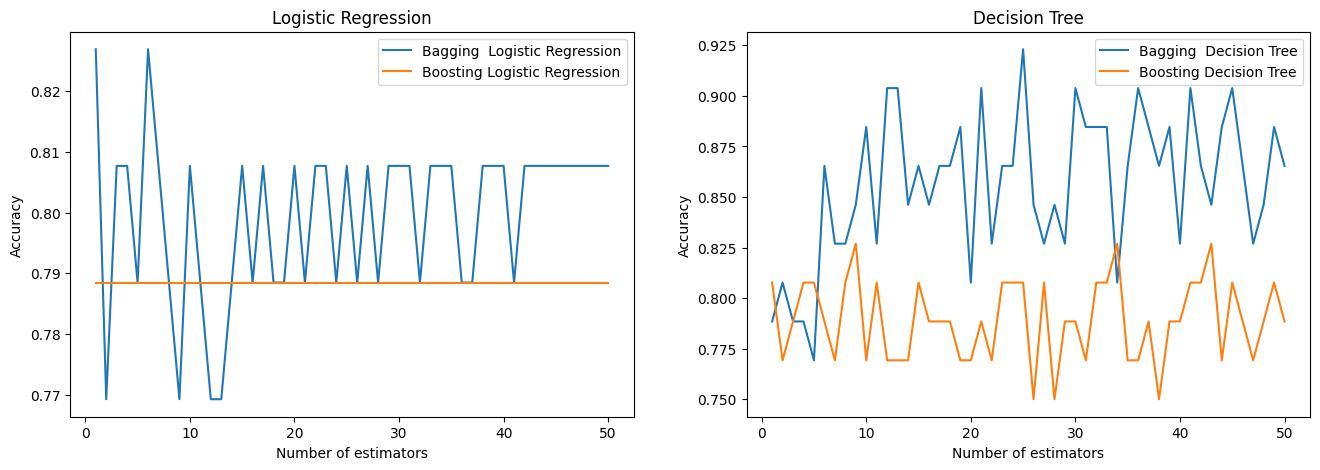

In [34]:
fig, axs = plt.subplots(1, len(mdls), figsize=(16,5))

for i, (mdl_name, mdl) in enumerate(mdls):
    axs[i].plot(MAX_ESTIMATORS_lst, mdls_perf[mdl_name]['bagging' ], label='Bagging  ' + mdl_name)
    axs[i].plot(MAX_ESTIMATORS_lst, mdls_perf[mdl_name]['boosting'], label='Boosting ' + mdl_name)

    axs[i].set_ylabel('Accuracy')
    axs[i].set_xlabel('Number of estimators')
    axs[i].set_title(mdl_name)
    axs[i].legend()


# plt.ylabel('Accuracy')
# plt.xlabel('Number of estimators')
# plt.legend()
#plt.rcParams["figure.figsize"] = (3,7)
plt.show()

**TODO: Analyze the results**
1. Why Bagging is better than boosting in this experiment (according to the data)?
1. Propose a logical hypothesis to why Logistic Regression does not improve using boosting.
1. Why bagging is enhancing accuracy using decision trees?
1. Why boosting is not enhancing accuracy as much as bagging using decision trees?

**Answers**

1. Bagging appears to perform better than boosting in this experiment because it can reduce variance without increasing bias. This is useful for decision trees, which have high variance. By creating multiple trees and averaging their predictions

1.  because it’s already a low-variance but high-bias model. Boosting works by reducing bias, which is not the main issue with Logistic Regression. so, boosting might not lead to significant improvements.

1. Bagging enhances accuracy with decision trees because it reduces their tendency to overfit. Decision trees have high variance and can fit too closely to their training data. Bagging mitigates this by averaging the predictions of multiple trees, leading to a more robust and accurate model.


1. because it focuses on reducing bias, not variance. Decision trees are high-variance models, so they benefit more from bagging, which reduces variance. Boosting might not be as effective because it could lead to overfitting by trying to correct the misclassifications of the previous trees.

#### II.2.2. Bootstrap's size

In this expreiment, we are interested in bagging; more precisely, Bootstrap's size.

*P.S. We used SGD instead of linear logistic regression because this latter has some problems with bagging*

In [35]:
BAG_PERC_lst = np.arange(0.1, 1, 0.01)

mdls_bag = [
    ('Logistic Regression', SGDClassifier()),
    # ('Logistic Regression', LogisticRegression(solver='liblinear')), 
    ('Decision Tree', DecisionTreeClassifier(random_state=0))
]

mdls_bag_perf = {}
for mdl_name, mdl in mdls_bag:
    mdls_bag_perf[mdl_name] = {'train': [], 'test': []}

for max_samples in BAG_PERC_lst:
    for mdl_name, mdl in mdls_bag:
        mdl_bagging  = BaggingClassifier (estimator=mdl, n_estimators=20, max_samples=max_samples)

        mdl_bagging.fit(X_cars_train, Y_cars_train)
        Y_pred = mdl_bagging.predict(X_cars_train)
        mdls_bag_perf[mdl_name]['train'].append(accuracy_score(Y_cars_train, Y_pred))

        Y_pred = mdl_bagging.predict(X_cars_test)
        mdls_bag_perf[mdl_name]['test'].append(accuracy_score(Y_cars_test, Y_pred))

print('DONE')

DONE


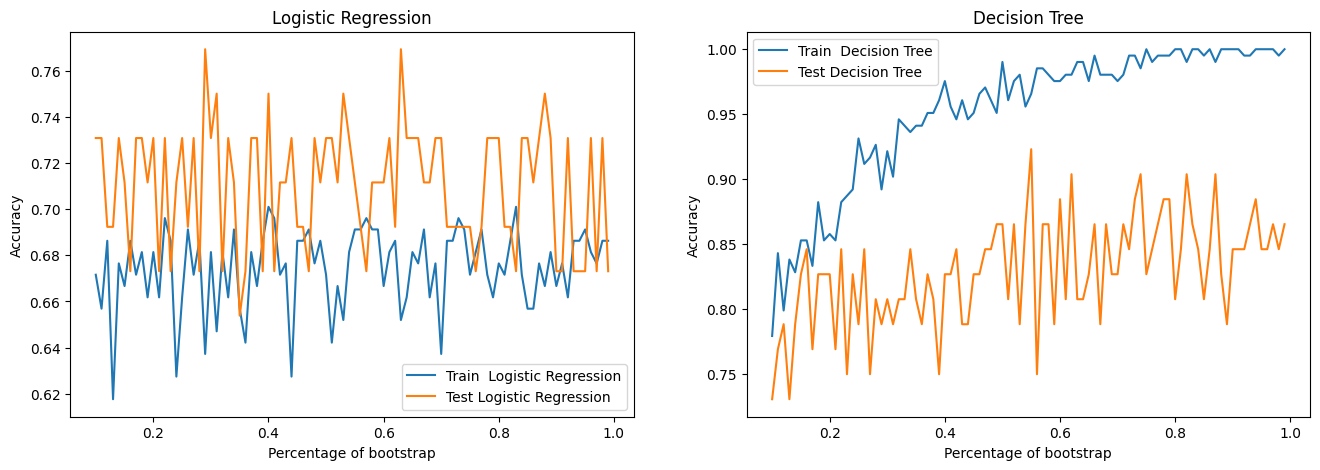

In [36]:
fig, axs = plt.subplots(1, len(mdls_bag), figsize=(16,5))

for i, (mdl_name, mdl) in enumerate(mdls_bag):
    axs[i].plot(BAG_PERC_lst, mdls_bag_perf[mdl_name]['train' ], label='Train  ' + mdl_name)
    axs[i].plot(BAG_PERC_lst, mdls_bag_perf[mdl_name]['test']  , label='Test '   + mdl_name)

    axs[i].set_ylabel('Accuracy')
    axs[i].set_xlabel('Percentage of bootstrap')
    axs[i].set_title(mdl_name)
    axs[i].legend()


# plt.ylabel('Accuracy')
# plt.xlabel('Number of estimators')
# plt.legend()
#plt.rcParams["figure.figsize"] = (3,7)
plt.show()

**TODO: Analyze the results**
1. Why the accuracy's cruve is not smooth?
1. Why increasing the size of a bootstrap increases the accuracy in case of decision trees?
1. Why it does not in case of logistic regression?

**Answers**

1. The accuracy curve is not smooth because the performance of the models can vary significantly depending on the specific subset of data used for training.  when using bootstrap sampling, as different samples can contain very different data points.
1. Increasing the bootstrap size means that each decision tree in the ensemble has more data to learn from, which  lead to more accurate and generalized models. Decision trees can handle large datasets well, and more data can help them capture complex patterns.
1. Increasing the bootstrap size doesn’t improve the accuracy in Logistic Regression because it’s a parametric model with specific assumptions about the data. If these assumptions aren’t met, more data won’t help and could even degrade performance. Also, Logistic Regression is less prone to overfitting compared to Decision Trees, so it does not benefit as much from Bagging

In [37]:
print('Trees and forests are crucial for life on earth')
print('Not these trees though :)')

Trees and forests are crucial for life on earth
Not these trees though :)
